**CLASSIFICATION**

In [ ]:
import pandas as pd
df=pd.read_csv('M4.csv')

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from collections import defaultdict
import numpy as np
import time

def tune_classifiers(X_train, y_train, X_test, y_test, use_random_search=False, cv=5, best_params_dict=None):
    results = {}

    classifiers = {
        "Logistic Regression": (LogisticRegression(max_iter=1000), {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__solver': ['lbfgs', 'liblinear']
        }),
        "Naive Bayes": (GaussianNB(), {}),
        "K-Nearest Neighbors": (KNeighborsClassifier(), {
            'clf__n_neighbors': [3, 5, 7, 11],
            'clf__weights': ['uniform', 'distance']
        }),
        "Decision Tree": (DecisionTreeClassifier(random_state=42), {
            'clf__max_depth': [15, 25, 35],
            'clf__min_samples_split': [2, 5, 10],
            'clf__criterion': ['gini', 'entropy']
        }),
        "Random Forest": (RandomForestClassifier(random_state=42), {
            'clf__n_estimators': [500, 1000],
            'clf__max_depth': [50, None],
            'clf__max_features': ['sqrt', 'log2']
        }),
        "Extra Trees": (ExtraTreesClassifier(random_state=42), {
            'clf__n_estimators': [100, 300],
            'clf__max_depth': [None, 50]
        }),
        "AdaBoost": (AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), random_state=42), {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.01, 0.1]
        }),
        "Gradient Boosting": (GradientBoostingClassifier(random_state=42), {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.05, 0.1],
            'clf__max_depth': [3, 4]
        }),
        "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.05, 0.1],
            'clf__max_depth': [3, 4]
        }),
        "LightGBM": (LGBMClassifier(random_state=242), {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.05, 0.1],
            'clf__num_leaves': [15, 31]
        }),
        "Support Vector Machine": (SVC(probability=True, random_state=42), {
            'clf__C': [0.1, 1],
            'clf__gamma': ['scale', 'auto']
        }),
        "Neural Network": (MLPClassifier(max_iter=5000, random_state=42), {
            'clf__hidden_layer_sizes': [(50, 10), (100, 50)],
            'clf__alpha': [0.005, 0.001],
            'clf__learning_rate': ['constant', 'adaptive']
        }),
    }

    for name, (model, param_grid) in classifiers.items():
        print(f"\n🔧 Tuning {name}...")
        model_start = time.time()

        if best_params_dict and name in best_params_dict:
            # Reuse best params
            model_params = {k.replace('clf__', ''): v for k, v in best_params_dict[name].items()}
            model.set_params(**model_params)
            pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
            pipe.fit(X_train, y_train)
            best_model = pipe
            best_params = best_params_dict[name]

        else:
            # Perform tuning
            pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
            if param_grid:  # only tune if params exist
                search = (RandomizedSearchCV(pipe, param_distributions=param_grid, n_iter=10,
                                             cv=cv, n_jobs=-1, scoring='accuracy', verbose=0)
                          if use_random_search else
                          GridSearchCV(pipe, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=0))
                search.fit(X_train, y_train)
                best_model = search.best_estimator_
                best_params = search.best_params_
            else:
                pipe.fit(X_train, y_train)
                best_model = pipe
                best_params = {}

        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test) if hasattr(best_model, "predict_proba") else None

        f1 = f1_score(y_test, y_pred, average='macro')
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        roc = roc_auc_score(y_test, y_prob, multi_class='ovr') if y_prob is not None else np.nan

        model_end = time.time()
        elapsed_model = model_end - model_start

        print(f"{name} Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, "
              f"Recall: {recall:.4f}, ROC AUC: {roc:.4f}, ⏱ Time: {elapsed_model:.2f} sec")

        results[name] = {
            'accuracy': acc,
            'F1 score': f1,
            'precision': precision,
            'recall': recall,
            'ROC AUC': roc,
            'best_model': best_model,
            'best_params': best_params,
            'time': elapsed_model
        }

    return results


# ---- Load Data ----

df=pd.read_csv('M4.csv')
X = df.drop(columns=["crystal_system"])
y = df["crystal_system"]

if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

runs = 5
aggregated_results = defaultdict(list)
best_param_store = {}

for i in range(runs):
    print(f"\n⏱ Run {i+1} of {runs}...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=242 + i, stratify=y
    )

    if i == 0:
        run_results = tune_classifiers(X_train, y_train, X_test, y_test, use_random_search=False, cv=3)
        best_param_store = {model_name: result['best_params'] for model_name, result in run_results.items()}
    else:
        run_results = tune_classifiers(X_train, y_train, X_test, y_test, cv=3, best_params_dict=best_param_store)

    for model_name, scores in run_results.items():
        aggregated_results[model_name].append(scores)

# ---- Averaging across runs ----
summary = {}
for model, runs_scores in aggregated_results.items():
    summary[model] = {
        'Avg Accuracy': round(np.mean([r['accuracy'] for r in runs_scores]), 4),
        'Avg F1 Score': round(np.mean([r['F1 score'] for r in runs_scores]), 4),
        'Avg Precision': round(np.mean([r['precision'] for r in runs_scores]), 4),
        'Avg Recall': round(np.mean([r['recall'] for r in runs_scores]), 4),
        'Avg ROC AUC': round(np.nanmean([r['ROC AUC'] for r in runs_scores]), 4),
        'Avg Time (sec)': round(np.mean([r['time'] for r in runs_scores]), 2),
        'Best Params (from first run)': best_param_store[model]
    }

summary_df = pd.DataFrame(summary).T.reset_index().rename(columns={'index': 'Model'})
summary_df.to_csv("M4_Averaged_Results.csv", index=False)

print("\n✅ Averaged results with timings saved to 'M4_Averaged_Results.csv'")


⏱ Run 1 of 5...

🔧 Tuning Logistic Regression...
Logistic Regression Accuracy: 0.6322, F1: 0.6233, Precision: 0.6239, Recall: 0.6322, ROC AUC: 0.8378, ⏱ Time: 10.65 sec

🔧 Tuning Naive Bayes...
Naive Bayes Accuracy: 0.5346, F1: 0.5111, Precision: 0.5212, Recall: 0.5346, ROC AUC: 0.7752, ⏱ Time: 0.08 sec

🔧 Tuning K-Nearest Neighbors...
K-Nearest Neighbors Accuracy: 0.9090, F1: 0.9065, Precision: 0.9121, Recall: 0.9090, ROC AUC: 0.9685, ⏱ Time: 3.97 sec

🔧 Tuning Decision Tree...
Decision Tree Accuracy: 0.8777, F1: 0.8768, Precision: 0.8765, Recall: 0.8777, ROC AUC: 0.9185, ⏱ Time: 13.03 sec

🔧 Tuning Random Forest...
Random Forest Accuracy: 0.9320, F1: 0.9315, Precision: 0.9314, Recall: 0.9320, ROC AUC: 0.9922, ⏱ Time: 481.95 sec

🔧 Tuning Extra Trees...
Extra Trees Accuracy: 0.9419, F1: 0.9414, Precision: 0.9413, Recall: 0.9419, ROC AUC: 0.9944, ⏱ Time: 23.81 sec

🔧 Tuning AdaBoost...
AdaBoost Accuracy: 0.7269, F1: 0.7242, Precision: 0.7274, Recall: 0.7269, ROC AUC: 0.9108, ⏱ Time: 1

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:21:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.8921, F1: 0.8910, Precision: 0.8909, Recall: 0.8921, ROC AUC: 0.9805, ⏱ Time: 30.52 sec

🔧 Tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 9712, number of used features: 27
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.9411, F1: 0.9409, Precision: 0.9410, Recall: 0.9411, ROC AUC: 0.9927, ⏱ Time: 59.01 sec

🔧 Tuning Support Vector Machine...
Support Vector Machine Accuracy: 0.8526, F1: 0.8496, Precision: 0.8514, Recall: 0.8526, ROC AUC: 0.9696, ⏱ Time: 161.65 sec

🔧 Tuning Neural Network...
Neural Network Accuracy: 0.9325, F1: 0.9318, Precision: 0.9322, Recall: 0.9325, ROC AUC: 0.9864, ⏱ Time: 296.65 sec

⏱ Run 2 of 5...

🔧 Tuning Logistic Regression...
Logistic Regression Accuracy: 0.6273, F1: 0.6183, Precision: 0.6172, Recall: 0.6273, ROC AUC: 0.8384, ⏱ Time: 1.83 sec

🔧 Tuning Naive Bayes...
Naive Bayes Accuracy: 0.5231, F1: 0.4983, Precision: 0.5077, Recall: 0.5231, ROC AUC: 0.7663, ⏱ Time: 0.08 sec

🔧 Tuning K-Nearest Neighbors...
K-Nearest Neighbors Accuracy: 0.9044, F1: 0.9024, Precision: 0.9057, Recall: 0.9044, ROC AUC: 0.9692, ⏱ Time: 0.35 sec

🔧 Tuning Decision Tree...
Decision Tree Accuracy: 0.8707, F1: 0.8700, Precision: 0.8696, Recall: 0.8707, ROC AUC: 0.9138, ⏱ Time:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:33:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.8789, F1: 0.8776, Precision: 0.8772, Recall: 0.8789, ROC AUC: 0.9813, ⏱ Time: 2.18 sec

🔧 Tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6264
[LightGBM] [Info] Number of data points in the train set: 9712, number of used features: 27
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.9362, F1: 0.9359, Precision: 0.9358, Recall: 0.9362, ROC AUC: 0.9932, ⏱ Time: 4.45 sec

🔧 Tuning Support Vector Machine...
Support Vector Machine Accuracy: 0.8431, F1: 0.8399, Precision: 0.8408, Recall: 0.8431, ROC AUC: 0.9696, ⏱ Time: 21.73 sec

🔧 Tuning Neural Network...
Neural Network Accuracy: 0.9296, F1: 0.9292, Precision: 0.9290, Recall: 0.9296, ROC AUC: 0.9870, ⏱ Time: 21.69 sec

⏱ Run 3 of 5...

🔧 Tuning Logistic Regression...
Logistic Regression Accuracy: 0.6417, F1: 0.6353, Precision: 0.6347, Recall: 0.6417, ROC AUC: 0.8447, ⏱ Time: 2.98 sec

🔧 Tuning Naive Bayes...
Naive Bayes Accuracy: 0.5379, F1: 0.5175, Precision: 0.5258, Recall: 0.5379, ROC AUC: 0.7731, ⏱ Time: 0.06 sec

🔧 Tuning K-Nearest Neighbors...
K-Nearest Neighbors Accuracy: 0.9193, F1: 0.9175, Precision: 0.9209, Recall: 0.9193, ROC AUC: 0.9728, ⏱ Time: 0.37 sec

🔧 Tuning Decision Tree...
Decision Tree Accuracy: 0.8781, F1: 0.8781, Precision: 0.8782, Recall: 0.8781, ROC AUC: 0.9187, ⏱ Time: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:37:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9028, F1: 0.9021, Precision: 0.9023, Recall: 0.9028, ROC AUC: 0.9837, ⏱ Time: 2.28 sec

🔧 Tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 9712, number of used features: 27
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.9485, F1: 0.9485, Precision: 0.9485, Recall: 0.9485, ROC AUC: 0.9945, ⏱ Time: 5.49 sec

🔧 Tuning Support Vector Machine...
Support Vector Machine Accuracy: 0.8624, F1: 0.8601, Precision: 0.8603, Recall: 0.8624, ROC AUC: 0.9720, ⏱ Time: 21.10 sec

🔧 Tuning Neural Network...
Neural Network Accuracy: 0.9316, F1: 0.9311, Precision: 0.9314, Recall: 0.9316, ROC AUC: 0.9896, ⏱ Time: 24.44 sec

⏱ Run 4 of 5...

🔧 Tuning Logistic Regression...
Logistic Regression Accuracy: 0.6277, F1: 0.6194, Precision: 0.6194, Recall: 0.6277, ROC AUC: 0.8400, ⏱ Time: 2.51 sec

🔧 Tuning Naive Bayes...
Naive Bayes Accuracy: 0.5313, F1: 0.5063, Precision: 0.5179, Recall: 0.5313, ROC AUC: 0.7695, ⏱ Time: 0.08 sec

🔧 Tuning K-Nearest Neighbors...
K-Nearest Neighbors Accuracy: 0.9131, F1: 0.9115, Precision: 0.9142, Recall: 0.9131, ROC AUC: 0.9738, ⏱ Time: 0.34 sec

🔧 Tuning Decision Tree...
Decision Tree Accuracy: 0.8678, F1: 0.8672, Precision: 0.8671, Recall: 0.8678, ROC AUC: 0.9119, ⏱ Time: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:40:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.8843, F1: 0.8834, Precision: 0.8836, Recall: 0.8843, ROC AUC: 0.9815, ⏱ Time: 3.09 sec

🔧 Tuning LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6263
[LightGBM] [Info] Number of data points in the train set: 9712, number of used features: 27
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.9456, F1: 0.9454, Precision: 0.9454, Recall: 0.9456, ROC AUC: 0.9940, ⏱ Time: 4.68 sec

🔧 Tuning Support Vector Machine...
Support Vector Machine Accuracy: 0.8620, F1: 0.8598, Precision: 0.8612, Recall: 0.8620, ROC AUC: 0.9707, ⏱ Time: 21.77 sec

🔧 Tuning Neural Network...
Neural Network Accuracy: 0.9395, F1: 0.9389, Precision: 0.9391, Recall: 0.9395, ROC AUC: 0.9886, ⏱ Time: 21.59 sec

⏱ Run 5 of 5...

🔧 Tuning Logistic Regression...
Logistic Regression Accuracy: 0.6318, F1: 0.6258, Precision: 0.6249, Recall: 0.6318, ROC AUC: 0.8438, ⏱ Time: 2.28 sec

🔧 Tuning Naive Bayes...
Naive Bayes Accuracy: 0.5375, F1: 0.5167, Precision: 0.5246, Recall: 0.5375, ROC AUC: 0.7762, ⏱ Time: 0.04 sec

🔧 Tuning K-Nearest Neighbors...
K-Nearest Neighbors Accuracy: 0.9090, F1: 0.9071, Precision: 0.9104, Recall: 0.9090, ROC AUC: 0.9676, ⏱ Time: 0.37 sec

🔧 Tuning Decision Tree...
Decision Tree Accuracy: 0.8612, F1: 0.8605, Precision: 0.8603, Recall: 0.8612, ROC AUC: 0.9075, ⏱ Time: 0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:44:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.8830, F1: 0.8819, Precision: 0.8815, Recall: 0.8830, ROC AUC: 0.9792, ⏱ Time: 4.15 sec

🔧 Tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6256
[LightGBM] [Info] Number of data points in the train set: 9712, number of used features: 27
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.9390, F1: 0.9390, Precision: 0.9389, Recall: 0.9390, ROC AUC: 0.9917, ⏱ Time: 4.52 sec

🔧 Tuning Support Vector Machine...
Support Vector Machine Accuracy: 0.8493, F1: 0.8470, Precision: 0.8474, Recall: 0.8493, ROC AUC: 0.9696, ⏱ Time: 21.83 sec

🔧 Tuning Neural Network...
Neural Network Accuracy: 0.9292, F1: 0.9283, Precision: 0.9282, Recall: 0.9292, ROC AUC: 0.9857, ⏱ Time: 29.55 sec

✅ Averaged results with timings saved to 'M4_Averaged_Results.csv'


**SHAP ANALYSIS**

In [8]:
import pandas as pd
import numpy as np
import os
import shap
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import lightgbm as lgb

# ===========================
# Setup
# ===========================
df = pd.read_csv('M4.csv')
target_column = 'crystal_system'
output_dir = "shap_outputs"
os.makedirs(output_dir, exist_ok=True)

# Encode categorical features except target
for col in df.select_dtypes(include=['object']).columns:
    if col != target_column:
        df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=[target_column])
y = df[target_column]

# Store original class names before encoding
class_names = list(np.unique(y))
print("Crystal System Classes:", class_names)

# Encode target if categorical
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===========================
# Model dictionary
# ===========================
models = {
    "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "ExtraTrees": ExtraTreesClassifier(random_state=42, n_jobs=-1),
    "LGBM": lgb.LGBMClassifier(random_state=42, n_jobs=-1)
}

# ===========================
# Function to compute SHAP
# ===========================
def run_shap(model, model_name, scale_factor=1.0):
    print(f"\n🔹 {model_name} 🔹")
    start_time = time.time()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2f}")

    # SHAP analysis
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Handle SHAP output shapes
    if isinstance(shap_values, list):
        shap_array = np.mean([np.abs(sv) for sv in shap_values], axis=0)
    elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
        shap_array = np.mean(np.abs(shap_values), axis=2)
    else:
        shap_array = np.abs(shap_values)

    # Mean importance per feature
    mean_importance = (np.mean(shap_array, axis=0)) * scale_factor
    feature_importance_df = pd.DataFrame({
        "Feature": X_test.columns,
        model_name: mean_importance
    }).sort_values(by=model_name, ascending=False)

    # Save individual CSV
    csv_path = os.path.join(output_dir, f"{model_name}_shap_importance.csv")
    feature_importance_df.to_csv(csv_path, index=False, float_format="%.6f")
    print(f"🔸 Saved: {csv_path}")

    # --- SHAP Plot: Top 10 Features ---
    top10_features = feature_importance_df.head(10)["Feature"].tolist()
    X_test_top10 = X_test[top10_features]

    if isinstance(shap_values, list):
        shap_values_top10 = [sv[:, [X_test.columns.get_loc(f) for f in top10_features]] * scale_factor
                             for sv in shap_values]
    else:
        shap_values_top10 = shap_values[:, [X_test.columns.get_loc(f) for f in top10_features]] * scale_factor

    plt.figure()
    shap.summary_plot(
        shap_values_top10,
        X_test_top10,
        plot_type="bar",
        show=False,
        class_names=class_names
    )
    plt.title(f"{model_name}")
    plt.gca().set_xlabel("")  # Remove default SHAP label
    plt.tight_layout()

    plot_path = os.path.join(output_dir, f"{model_name}_shap_top10_plot.png")
    plt.savefig(plot_path, bbox_inches="tight", dpi=400)
    plt.close()

    elapsed = time.time() - start_time
    print(f"⏱ Time taken: {elapsed:.2f} seconds")

    return feature_importance_df

# ===========================
# Run all models
# ===========================
rf_importance = run_shap(models["RandomForest"], "RandomForest")
et_importance = run_shap(models["ExtraTrees"], "ExtraTrees")
lgbm_importance = run_shap(models["LGBM"], "LGBM", scale_factor=0.1)  # ⬅ LGBM scaled

# ===========================
# Merge into Combined CSV
# ===========================
combined_df = rf_importance.merge(et_importance, on="Feature").merge(lgbm_importance, on="Feature")
combined_df["Mean Importance"] = combined_df[["RandomForest", "ExtraTrees", "LGBM"]].mean(axis=1)
combined_df = combined_df.sort_values(by="Mean Importance", ascending=False)

combined_csv = os.path.join(output_dir, "Combined_SHAP_Importance_M4.csv")
combined_df.to_csv(combined_csv, index=False, float_format="%.6f")
print(f"\n✅ Final combined SHAP CSV saved: {combined_csv}")


Crystal System Classes: ['Cubic', 'Orthorhombic', 'Tetragonal', 'Trigonal']

🔹 RandomForest 🔹
Accuracy: 0.94
🔸 Saved: shap_outputs/RandomForest_shap_importance.csv
⏱ Time taken: 228.75 seconds

🔹 ExtraTrees 🔹
Accuracy: 0.95
🔸 Saved: shap_outputs/ExtraTrees_shap_importance.csv
⏱ Time taken: 591.67 seconds

🔹 LGBM 🔹
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6264
[LightGBM] [Info] Number of data points in the train set: 9712, number of used features: 27
[LightGBM] [Info] Start training from score -1.394151
[LightGBM] [Info] Start training from score -1.386706
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.378091
Accuracy: 0.94
🔸 Saved: shap_outputs/LGBM_shap_importance.csv
⏱ Time taken: 13.73 seconds

✅ Final combined SHAP CSV saved: shap_outputs/Combined_SHAP_Importance_M4.csv


/tmp/ipython-input-2815453225.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


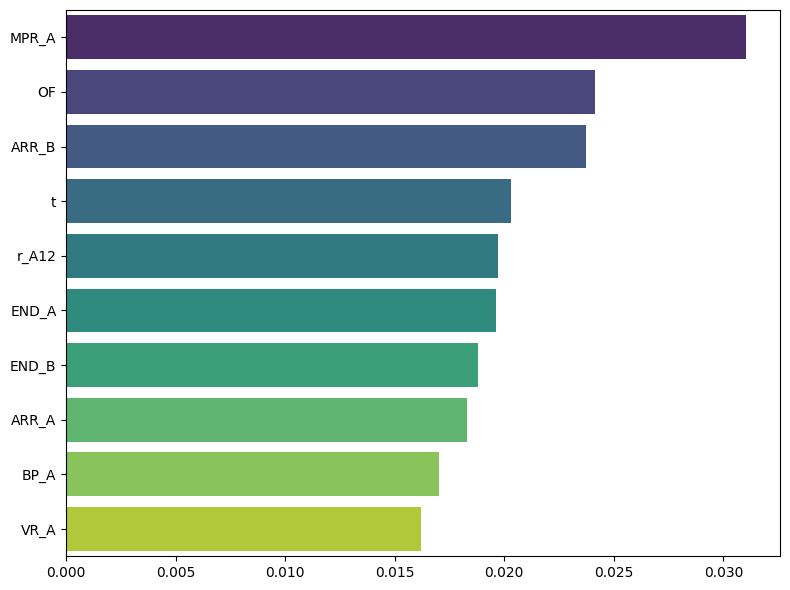

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
df = pd.read_csv('Combined_SHAP_Importance_M4.csv')

# Sort by Mean Importance and take top 10
top10 = df.sort_values("Mean Importance", ascending=False).head(10)

# Plot top 10 features
plt.figure(figsize=(8, 6))
sns.barplot(
    data=top10,
    y="Feature",
    x="Mean Importance",
    palette="viridis"
)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.savefig("top10_features_M4.png", dpi=400)
plt.show()
plt.close()

**Classification with reduced features**

In [12]:
import pandas as pd
df=pd.read_csv('M4.csv')
#Features to keep
features = ["MPR_A","OF","ARR_B","t","r_A12","END_A","END_B","ARR_A","BP_A","VR_A","crystal_system"]
df = df[features]
df.columns

Index(['MPR_A', 'OF', 'ARR_B', 't', 'r_A12', 'END_A', 'END_B', 'ARR_A', 'BP_A',
       'VR_A', 'crystal_system'],
      dtype='object')

In [13]:
# ---------------- Classification: RF, ET, LGBM only ----------------
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from collections import defaultdict
import numpy as np
import time

def tune_classifiers(X_train, y_train, X_test, y_test, cv=3, best_params_dict=None):
    results = {}

    classifiers = {
        "Random Forest": (RandomForestClassifier(random_state=42), {
            'clf__n_estimators': [500, 1000],
            'clf__max_depth': [50, None],
            'clf__max_features': ['sqrt', 'log2']
        }),
        "Extra Trees": (ExtraTreesClassifier(random_state=42), {
            'clf__n_estimators': [100, 300],
            'clf__max_depth': [None, 50]
        }),
        "LightGBM": (LGBMClassifier(random_state=242), {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.05, 0.1],
            'clf__num_leaves': [15, 31]
        })
    }

    for name, (model, param_grid) in classifiers.items():
        print(f"\n🔧 Tuning {name}...")
        start = time.time()

        if best_params_dict and name in best_params_dict:
            # Reuse best params
            model_params = {k.replace('clf__', ''): v for k, v in best_params_dict[name].items()}
            model.set_params(**model_params)
            pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
            pipe.fit(X_train, y_train)
            best_model = pipe
            best_params = best_params_dict[name]
        else:
            # Tune with GridSearch
            pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
            search = GridSearchCV(pipe, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=0)
            search.fit(X_train, y_train)
            best_model = search.best_estimator_
            best_params = search.best_params_

        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test) if hasattr(best_model, "predict_proba") else None

        f1 = f1_score(y_test, y_pred, average='macro')
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        roc = roc_auc_score(y_test, y_prob, multi_class='ovr') if y_prob is not None else np.nan

        elapsed = time.time() - start

        print(f"{name} Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, "
              f"Recall: {recall:.4f}, ROC AUC: {roc:.4f}, ⏱ {elapsed:.2f} sec")

        results[name] = {
            'accuracy': acc,
            'F1 score': f1,
            'precision': precision,
            'recall': recall,
            'ROC AUC': roc,
            'best_model': best_model,
            'best_params': best_params,
            'time': elapsed
        }

    return results


X = df.drop(columns=["crystal_system"])
y = df["crystal_system"]

if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- Repeated Runs ----
runs = 5
aggregated_results = defaultdict(list)
best_param_store = {}

for i in range(runs):
    print(f"\n⏱ Run {i+1} of {runs}...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=242 + i, stratify=y
    )

    if i == 0:
        run_results = tune_classifiers(X_train, y_train, X_test, y_test, cv=3)
        best_param_store = {model_name: result['best_params'] for model_name, result in run_results.items()}
    else:
        run_results = tune_classifiers(X_train, y_train, X_test, y_test, cv=3, best_params_dict=best_param_store)

    for model_name, scores in run_results.items():
        aggregated_results[model_name].append(scores)

# ---- Averaging results ----
summary = {}
for model, runs_scores in aggregated_results.items():
    summary[model] = {
        'Avg Accuracy': round(np.mean([r['accuracy'] for r in runs_scores]), 4),
        'Avg F1 Score': round(np.mean([r['F1 score'] for r in runs_scores]), 4),
        'Avg Precision': round(np.mean([r['precision'] for r in runs_scores]), 4),
        'Avg Recall': round(np.mean([r['recall'] for r in runs_scores]), 4),
        'Avg ROC AUC': round(np.nanmean([r['ROC AUC'] for r in runs_scores]), 4),
        'Avg Time (sec)': round(np.mean([r['time'] for r in runs_scores]), 2),
        'Best Params (from first run)': best_param_store[model]
    }

summary_df = pd.DataFrame(summary).T.reset_index().rename(columns={'index': 'Model'})
summary_df.to_csv("M4_reduced_results.csv", index=False)


⏱ Run 1 of 5...

🔧 Tuning Random Forest...
Random Forest Accuracy: 0.8942, F1: 0.8928, Precision: 0.8930, Recall: 0.8942, ROC AUC: 0.9817, ⏱ 346.00 sec

🔧 Tuning Extra Trees...
Extra Trees Accuracy: 0.8999, F1: 0.8988, Precision: 0.8987, Recall: 0.8999, ROC AUC: 0.9832, ⏱ 21.34 sec

🔧 Tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2472
[LightGBM] [Info] Number of data points in the train set: 9712, number of used features: 10
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.9077, F1: 0.9070, Precision: 0.9069, Recall: 0.9077, ROC AUC: 0.9853, ⏱ 30.73 sec

⏱ Run 2 of 5...

🔧 Tuning Random Forest...
Random Forest Accuracy: 0.8950, F1: 0.8940, Precision: 0.8937, Recall: 0.8950, ROC AUC: 0.9819, ⏱ 17.33 sec

🔧 Tuning Extra Trees...
Extra Trees Accuracy: 0.9098, F1: 0.9090, Precision: 0.9089, Recall: 0.9098, ROC AUC: 0.9836, ⏱ 4.14 sec

🔧 Tuning LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2473
[LightGBM] [Info] Number of data points in the train set: 9712, number of used features: 10
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.9086, F1: 0.9077, Precision: 0.9077, Recall: 0.9086, ROC AUC: 0.9860, ⏱ 2.56 sec

⏱ Run 3 of 5...

🔧 Tuning Random Forest...
Random Forest Accuracy: 0.8958, F1: 0.8950, Precision: 0.8947, Recall: 0.8958, ROC AUC: 0.9840, ⏱ 17.29 sec

🔧 Tuning Extra Trees...
Extra Trees Accuracy: 0.9044, F1: 0.9037, Precision: 0.9033, Recall: 0.9044, ROC AUC: 0.9844, ⏱ 3.86 sec

🔧 Tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2474
[LightGBM] [Info] Number of data points in the train set: 9712, number of used features: 10
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.9135, F1: 0.9130, Precision: 0.9128, Recall: 0.9135, ROC AUC: 0.9881, ⏱ 3.27 sec

⏱ Run 4 of 5...

🔧 Tuning Random Forest...
Random Forest Accuracy: 0.8933, F1: 0.8925, Precision: 0.8923, Recall: 0.8933, ROC AUC: 0.9834, ⏱ 18.15 sec

🔧 Tuning Extra Trees...
Extra Trees Accuracy: 0.9003, F1: 0.8995, Precision: 0.8991, Recall: 0.9003, ROC AUC: 0.9837, ⏱ 3.97 sec

🔧 Tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2471
[LightGBM] [Info] Number of data points in the train set: 9712, number of used features: 10
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.9180, F1: 0.9178, Precision: 0.9179, Recall: 0.9180, ROC AUC: 0.9883, ⏱ 3.15 sec

⏱ Run 5 of 5...

🔧 Tuning Random Forest...
Random Forest Accuracy: 0.8867, F1: 0.8862, Precision: 0.8860, Recall: 0.8867, ROC AUC: 0.9812, ⏱ 17.83 sec

🔧 Tuning Extra Trees...
Extra Trees Accuracy: 0.8954, F1: 0.8949, Precision: 0.8947, Recall: 0.8954, ROC AUC: 0.9821, ⏱ 3.62 sec

🔧 Tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2470
[LightGBM] [Info] Number of data points in the train set: 9712, number of used features: 10
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.9028, F1: 0.9027, Precision: 0.9029, Recall: 0.9028, ROC AUC: 0.9855, ⏱ 2.67 sec
